In [1]:
%pylab inline
from scipy.misc import imread, imresize

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Красивый вывод предсказаний сети
def print_predictions(decoded):
    print 'Predictions:'
    for synset, class_, prob in decoded:
        print '{} {:12s} {:.6f}'.format(synset, class_, prob)

# Семантическая сегментация

## Ожидание
Взяли готовую предобученнунную сетку VGG16 или там ResNet какой-нибудь. Скормили ей картинки - решили задачу.

In [3]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K20Xm (0000:20:00.0)


In [4]:
base_model = VGG16(weights='imagenet')

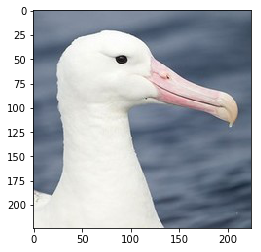

In [5]:
img_path = 'imgs/one/albatross.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)

In [6]:
x = image.img_to_array(img)
x = preprocess_input(x[np.newaxis, ...])

In [7]:
preds = base_model.predict(x)

In [8]:
print_predictions( decode_predictions(preds, top=5)[0] )

Predictions:
n02058221 albatross    0.996300
n01855672 goose        0.003694
n01847000 drake        0.000001
n02002556 white_stork  0.000001
n02006656 spoonbill    0.000001


### TL;DR: Умеем классифицировать, "что на картинке?"

## Реальность

![](data/VOC2012/JPEGImages/2007_001884.jpg)


![](data/VOC2012/SegmentationClass/2007_001884.png)

### Пример  из SYNTHIA

![](imgs/synthia.jpg)

### TL;DR: хотим классифицировать каждый пиксель картинки, отвечая на вопрос не только "что изображено?", но и "где именно?"

# Попытка 1

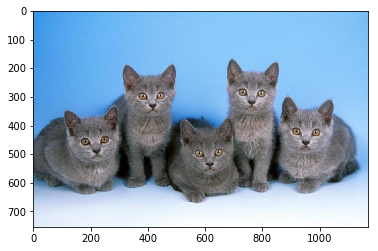

In [9]:
kittens = imread('imgs/kittens.jpg')
t = kittens
plt.imshow(t)

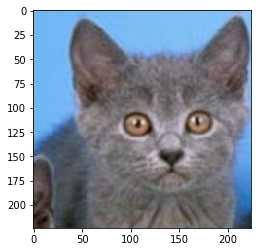

In [10]:
kitten = t[180:180+224, 300-24:500]
plt.imshow(kitten)

In [11]:
x = kitten.astype('float32')
x = preprocess_input(x[np.newaxis, ...])
preds = base_model.predict(x)

print_predictions(decode_predictions(preds, top=5)[0])

Predictions:
n02124075 Egyptian_cat 0.544302
n02123045 tabby        0.168734
n02123159 tiger_cat    0.076360
n02127052 lynx         0.059853
n02123394 Persian_cat  0.022297


In [12]:
from keras.applications.imagenet_utils import CLASS_INDEX
#CLASS_INDEX

# u'283': [u'n02123394', u'Persian_cat'],
# u'282': [u'n02123159', u'tiger_cat'],
# u'285': [u'n02124075', u'Egyptian_cat'],
# u'284': [u'n02123597', u'Siamese_cat']

In [13]:
preds[0][285]

0.54430151

In [14]:
def get_pred(x):
    x = x.astype('float32')[np.newaxis, ...]
    x = preprocess_input(x)
    preds = base_model.predict(x)
    return preds[0][285]

In [15]:
tmp_shape = (t.shape[0] - 223) / 20, (t.shape[1] - 223) / 20
all_preds = np.zeros( tmp_shape, dtype='float32')

print tmp_shape, all_preds.size

for i in range(all_preds.shape[0]):
    for j in range(all_preds.shape[1]):
        all_preds[i][j] = get_pred(t[i*20:i*20+224, j*20:j*20+224])

(26, 47) 1222


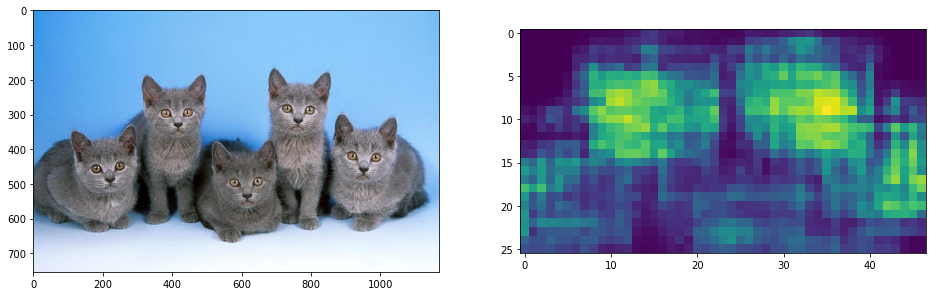

In [16]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16))
ax1.imshow(t)
ax2.imshow(all_preds)

# Попытка 2

In [17]:
from keras.utils import plot_model
plot_model(base_model, show_shapes=True, to_file='imgs/models/vgg16.png')

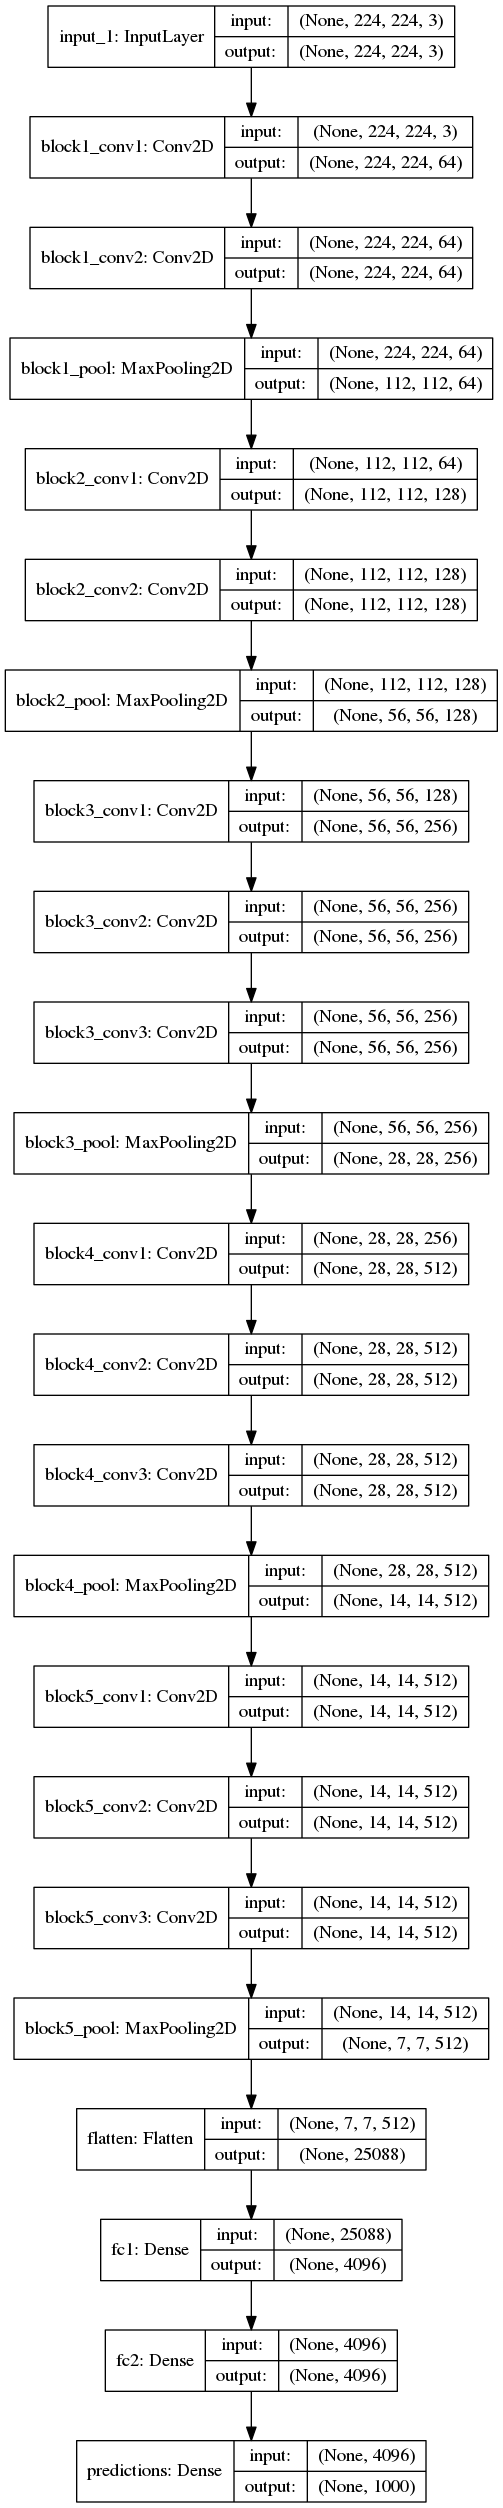

In [18]:
image.load_img('imgs/models/vgg16.png')

In [19]:
base_model.layers

In [20]:
print base_model.layers[-3].activation
print base_model.layers[-2].activation
print base_model.layers[-1].activation


<function relu at 0x7f83388e09b0>
<function relu at 0x7f83388e09b0>
<function softmax at 0x7f83388e07d0>


### Идея: сделаем полносвязные слои свёрточными
Для этого нам понадобится построить новую модель на основе уже обученной VGG16

In [21]:
from keras.layers import Conv2D
from keras.activations import relu, softmax
from keras.models import Model

In [22]:
x = base_model.layers[-5].output
x = Conv2D(filters=4096, kernel_size=(7,7), activation=relu)(x)
x = Conv2D(filters=4096, kernel_size=(1,1), activation=relu)(x)
out = Conv2D(filters=1000, kernel_size=(1,1), activation=softmax)(x)

In [23]:
model = Model(inputs=base_model.inputs, outputs=out)

In [24]:
def transplant_weights(dense, conv):
    W, b = dense.get_weights()
    shape = conv.get_weights()[0].shape
    new_W = W.reshape(*shape)[::-1, ::-1, :, :]
    conv.set_weights([new_W, b])
    

In [25]:
transplant_weights(base_model.layers[-3], model.layers[-3])
transplant_weights(base_model.layers[-2], model.layers[-2])
transplant_weights(base_model.layers[-1], model.layers[-1])

In [26]:
x = kitten.astype('float32')
x = preprocess_input(x[np.newaxis, ...])
preds1 = base_model.predict(x)
preds2 = model.predict(x)

print_predictions(decode_predictions(preds1, top=5)[0])
print_predictions(decode_predictions(preds2[0][0], top=5)[0])

Predictions:
n02124075 Egyptian_cat 0.544302
n02123045 tabby        0.168734
n02123159 tiger_cat    0.076360
n02127052 lynx         0.059853
n02123394 Persian_cat  0.022297
Predictions:
n02124075 Egyptian_cat 0.544302
n02123045 tabby        0.168734
n02123159 tiger_cat    0.076359
n02127052 lynx         0.059853
n02123394 Persian_cat  0.022297


In [27]:
#np.abs(preds1 - preds2) < 1e-7

In [28]:
x = kittens.astype('float32')
x = preprocess_input(x[np.newaxis, ...])
preds = model.predict(x)

ValueError: Error when checking : expected input_1 to have shape (None, 224, 224, 3) but got array with shape (1, 754, 1170, 3)

## Попытка 2.1

In [29]:
new_model = VGG16(include_top=False, input_shape=(None,None,3), weights='imagenet')

In [30]:
#new_model.layers

In [31]:
x = new_model.layers[-1].output
x = Conv2D(filters=4096, kernel_size=(7,7), activation=relu)(x)
x = Conv2D(filters=4096, kernel_size=(1,1), activation=relu)(x)
out = Conv2D(filters=1000, kernel_size=(1,1), activation=softmax)(x)
model = Model(inputs=new_model.inputs, outputs=out)

In [32]:
x = t.astype('float32')
x = preprocess_input(x[np.newaxis, ...])
preds = model.predict(x)

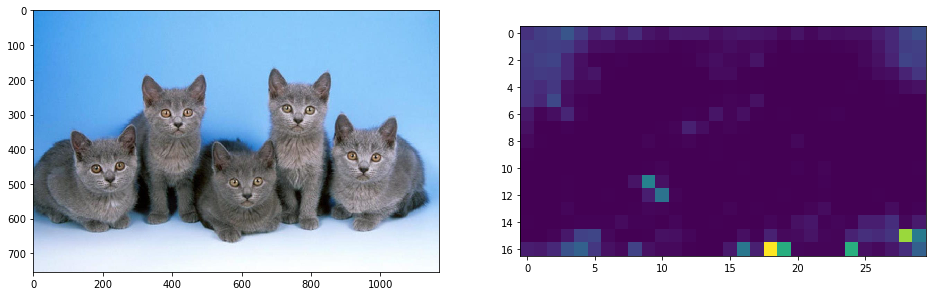

In [33]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16))
ax1.imshow(t)
ax2.imshow(preds[0, :, :, 285])

In [34]:
transplant_weights(base_model.layers[-3], model.layers[-3])
transplant_weights(base_model.layers[-2], model.layers[-2])
transplant_weights(base_model.layers[-1], model.layers[-1])

In [35]:
x = kittens.astype('float32')
x = preprocess_input(x[np.newaxis, ...])
preds = model.predict(x)

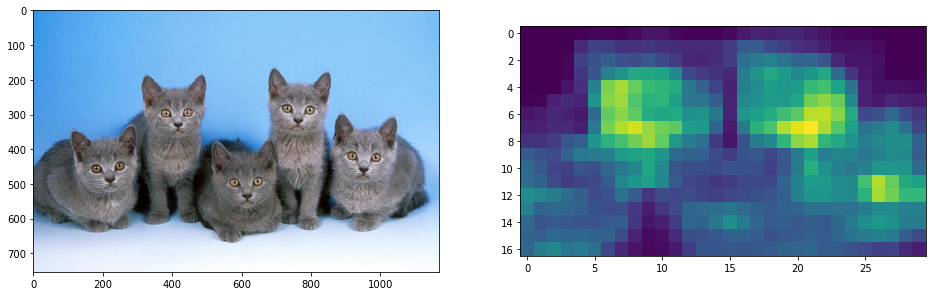

In [36]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16))
ax1.imshow(t)
ax2.imshow(preds[0, :, :, 285])

# Попытка 2.2: upsampling

In [37]:
kittens.shape, preds[0].shape

((754, 1170, 3), (17, 30, 1000))

In [38]:
# Утащено из https://github.com/shelhamer/fcn.berkeleyvision.org
def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


In [39]:
from keras.layers.convolutional import Conv2DTranspose
from keras.layers import Input

x = Input(shape=(None, None, 3))
y = model(x)
z = Conv2DTranspose(filters=1000, kernel_size=(8, 8), strides=(4, 4), kernel_initializer='zero', use_bias=False)(y)
model2 = Model(inputs=x, outputs=z)

In [40]:
params = model2.layers[-1].get_weights()
print params[0].shape

filt = upsample_filt(8)
for i in range(1000):
    params[0][:, :, i, i] = filt[::-1, ::-1]
    
model2.layers[-1].set_weights(params)

(8, 8, 1000, 1000)


In [41]:
x = kittens.astype('float32')
x = preprocess_input(x[np.newaxis, ...])
preds = model2.predict(x)
print preds[0].shape

(72, 124, 1000)


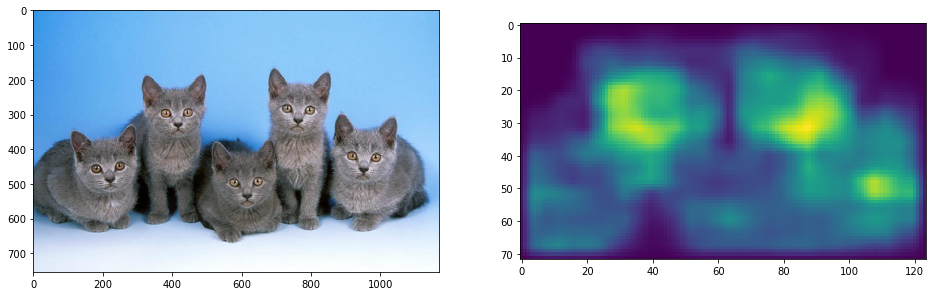

In [42]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16))
ax1.imshow(t)
ax2.imshow(preds[0, :, :, 285])